In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# from matplotlib import pyplot as plt
import pickle
import os
import shutil
import pandas as pd
import numpy as np
import math
import copy 
import networkx as nx
import grakel
import netlsd
import torch

from scipy import interpolate, signal, linalg, spatial
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, accuracy_score, make_scorer, r2_score
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.model_selection import cross_val_score
from sklearn.multioutput import RegressorMixin, RegressorChain
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import SpectralClustering, SpectralBiclustering, SpectralCoclustering, KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA
from numba import cuda, jit, njit, prange, vectorize

from collections import defaultdict, Counter
from itertools import combinations, product
from multiprocessing import cpu_count
from joblib import Parallel, delayed, pool
from IPython.display import clear_output, HTML
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook

from utils import compute_norm_laplacian_eig, get_first_k_eig, place_field_correlation

# N_CPU = cpu_count()
TOY_DATASET = False

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Create data

In [ ]:
track = 'Circle'
mouse = 22
day = 1
calcium_df = pd.read_csv(f"./data/{track}/data/CA1_{mouse}_{day}D_initial_data.csv", index_col=0)
spikes_df = pd.read_csv(f"./data/{track}/spikes/CA1_{mouse}_{day}D_initial_data_spikes.csv", index_col=0)
rears_events = pd.read_csv(f'./data/CA1_22-25_rears/CA1_{mouse}_{day}D_rears_from_npz.csv', index_col=0)

trim=100
cadata = calcium_df.iloc[:,7:][trim:-trim].T.values # [n_neurons, T] 
spdata = spikes_df.iloc[:,1:][trim:-trim].T.values # [n_neurons, T]
rears_events = rears_events[trim:-trim]

rear_times = rears_events['time_s'].values
rears_indicators = rears_events['rear_1_outward_-1_inward'].values
rears_indicators_abs = np.pad(np.abs(rears_indicators), pad_width=(T - rears_indicators.shape[0])//2)

cells_with_spikes = np.sum(spdata, axis = 1) > 1.

spdata = spdata[cells_with_spikes]
cadata = cadata[cells_with_spikes]

N, T = spdata.shape

# scaler = MinMaxScaler()
# spdata = scaler.fit_transform(spdata)
# cadata = scaler.fit_transform(cadata)

coords = calcium_df[['x','y']][trim:-trim].values
coords -= coords.mean(0)[None,:]
minmax_scaler = MinMaxScaler((-1,1))
coords_ = minmax_scaler.fit_transform(coords)

phi = np.arctan2(coords_[:,1], coords_[:,0])
phi[phi < 0] = 2*np.pi + phi[phi < 0]

# # speed sign
dphi = np.diff(phi, prepend=phi[0])
jump_mask = np.abs(dphi) > 6 # jump through breakpoint
dphi[jump_mask] = -1 * np.sign(dphi[jump_mask]) * np.abs(dphi[jump_mask] - 2*np.pi)
circle_sign = np.sign(dphi)

# speed
shift = np.diff(coords_, prepend=[coords_[0]], axis=0)
speed = np.sqrt((shift**2).sum(1)) * circle_sign

# acceleration
acceleration = np.diff(speed, prepend=speed[0])

acceleration_ = MinMaxScaler((0,1)).fit_transform(acceleration[:,None]).flatten()
speed_ = MinMaxScaler((-1,1)).fit_transform(speed[:,None]).flatten()
phi_ = MinMaxScaler().fit_transform(phi[:,None]).flatten()

targets = {
    'x': coords_[:,0],
    'y': coords_[:,1],
    'v': speed_,
    'a': acceleration_,
    'phi': phi
}

In [ ]:
plt.scatter(coords_[:,0], coords_[:,1], c=phi_)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

# Create toy dataset

In [3]:
# TOY_DATASET = True

# toy_steps_per_round = 1000
# dphi = 2*np.pi/toy_steps_per_round
# toy_neurons_per_place = 10
# toy_n_places = 4
# toy_timesteps = 5000
# toy_spdata = np.zeros((toy_n_places*toy_neurons_per_place, toy_timesteps))
# toy_phi = []

# for i in range(toy_timesteps):
#     j = i%(toy_steps_per_round) # index within round 
#     step = dphi*j
#     toy_phi.append(step)
#     # number of place
#     k = int(j//(toy_steps_per_round//toy_n_places))
    
#     if i%25==0 and j%(toy_steps_per_round//toy_n_places) != 0:
#         for m,random_offset in enumerate(np.random.choice(np.arange(-3,4), size=toy_neurons_per_place)):
#             toy_spdata[min(toy_neurons_per_place*toy_n_places - 1, (k*toy_neurons_per_place)+m),
#                        i+random_offset] = 1.
    
# toy_phi = np.array(toy_phi) #- np.pi
# x_toy = np.cos(toy_phi)
# y_toy = np.sin(toy_phi)

# plt.figure()
# plt.scatter(x_toy, y_toy, c=toy_phi)
# plt.show()

In [4]:
if TOY_DATASET:
    spdata = toy_spdata
    phi = toy_phi
    coords_ = np.stack([x_toy, y_toy],1)
    N, T = spdata.shape

In [5]:
print(TOY_DATASET)

False


# Read selective cells

In [123]:
dir_selective_cells = './CA1_22-25_circle_track_selctive_cells'
selective_cells_path = f'./CA1_22-25_circle_track_selctive_cells/CA1_{mouse}_{day}D_cells.txt'
# paths_selective_cells = [os.path.join(dir_selective_cells,p) for p in os.listdir(dir_selective_cells)]
with open(selective_cells_path) as f:
    selective_cells = f.readlines()
    
selective_cells = np.array([int(c) for c in selective_cells])
selective_cells = np.unique(selective_cells)
selective_cells = selective_cells[selective_cells < spdata.shape[0]]

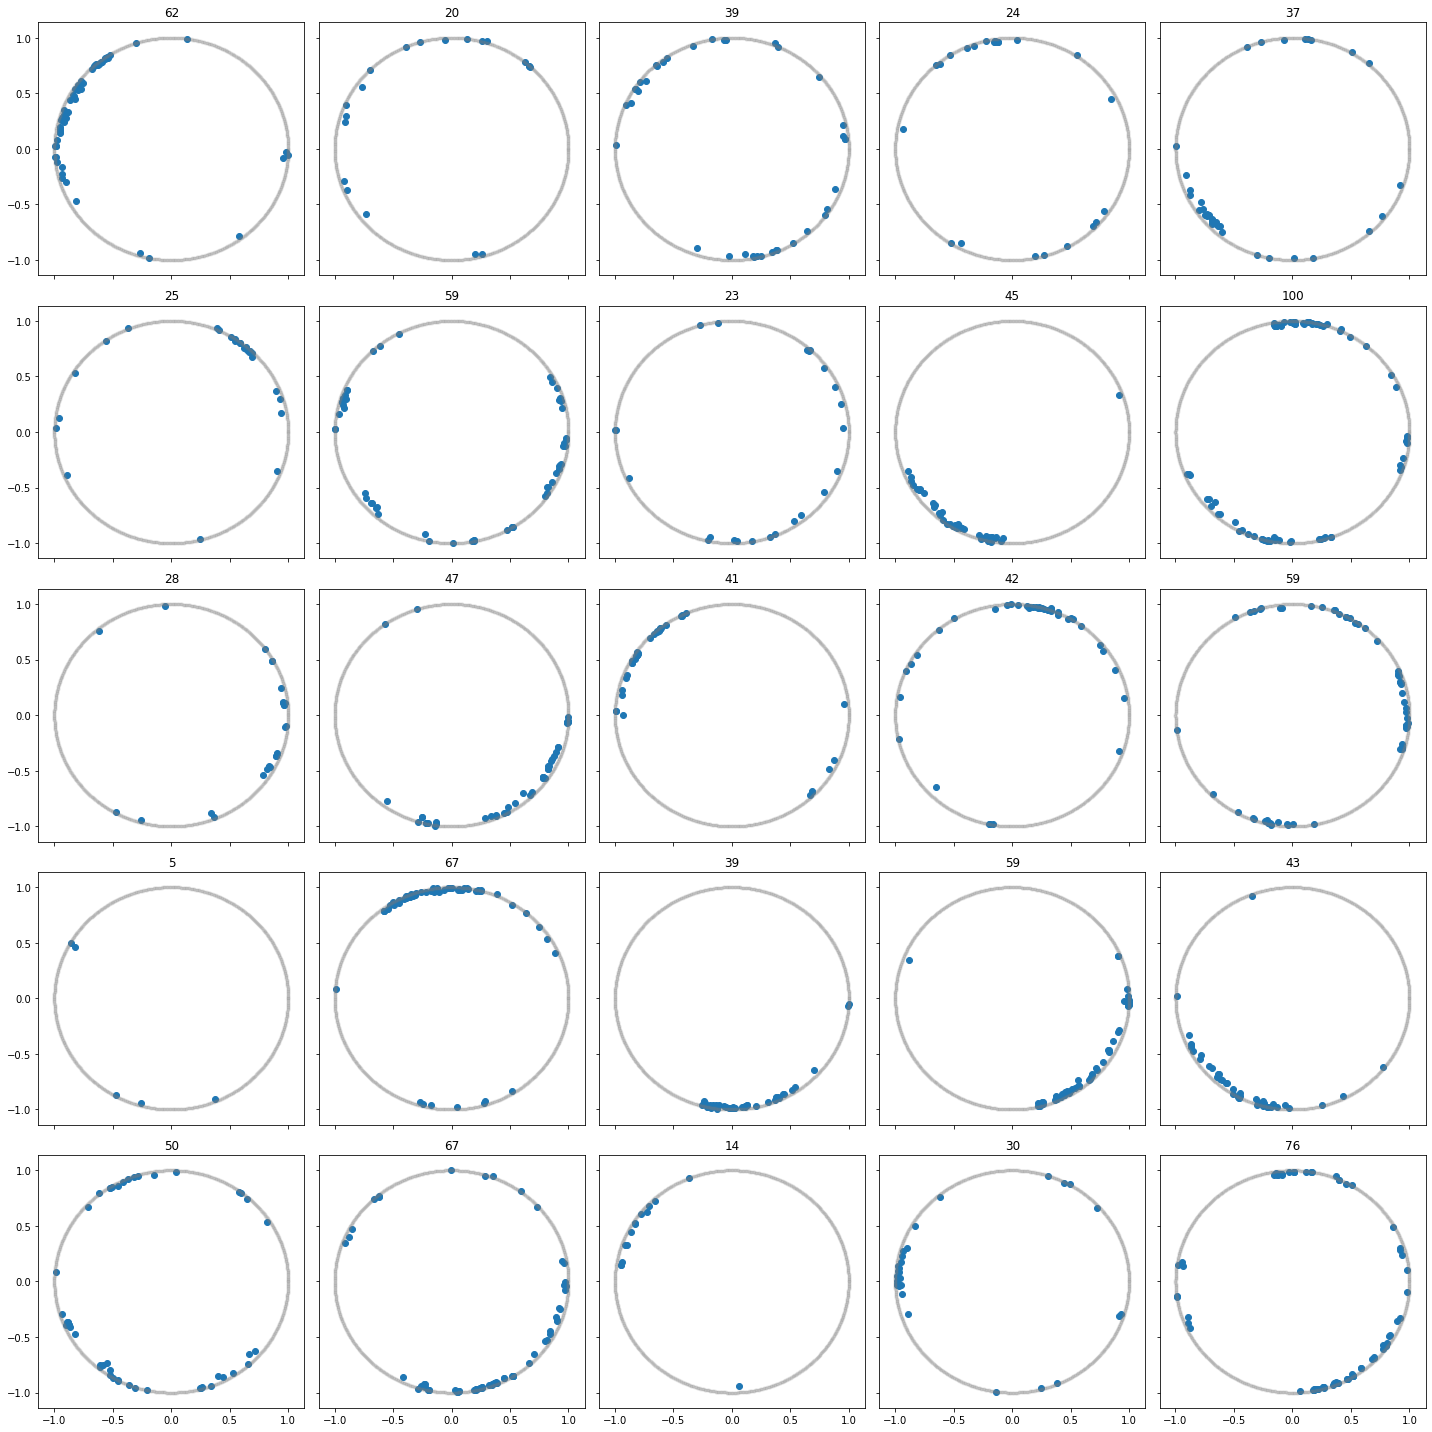

In [105]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20,20), sharex=True, sharey=True)
for ax,n in zip(axes.flatten(), selective_cells):
    xy = coords_[spdata_bool[n]]
    ax.scatter(xy[:,0], xy[:,1])
    angle_range = np.linspace(0, 2*np.pi, 1000)
    ax.scatter(np.cos(angle_range), np.sin(angle_range),color='grey', alpha=0.1, marker='.')
    ax.set_title(f'{len(xy)}')
plt.tight_layout()

In [398]:
# spikes_bool=spdata[:,3000:3000+dt].astype(bool)
# coordinates = coords_[3000:3000+dt]

# neuron_pfs = []
# H_nonzero = []
# for neuron_mask in spikes_bool:
#     coordinates_subsample = coordinates[neuron_mask]
#     if len(coordinates_subsample) > 0:
#         H,_,_ = np.histogram2d(coordinates_subsample[:,0], coordinates_subsample[:,1], bins=bins, range=[[-1, 1], [-1, 1]], density=True)
#         neuron_pfs.append(H.flatten()/H.sum())
#         if H.sum() > 100:
#             print(H.sum())
#             H_nonzero.append(H/H.sum())
#     else:
#         H = np.zeros((bins**2,))
#         neuron_pfs.append(H)
# neuron_pfs = np.array(neuron_pfs)
# norms = np.linalg.norm(neuron_pfs, axis=1, keepdims=True)
# S = neuron_pfs @ neuron_pfs.T / (norms @ norms.T + 1e-10)

пройтись гауссовым ядром по H? чтобы не такое жесткое условие было на близость?

In [399]:
# for H_i in H_nonzero[:10]:
#     plt.figure()
#     plt.imshow(H_i)
#     plt.show()

In [400]:
# plt.imshow(S)
# plt.title(r'$P$')
# plt.show()

# Choose neurons subset

 - let's calculate SP-similarity for expanding group of neurons starting from the most specific ones

In [110]:
# spdata_bool = spdata.astype(bool)

# stds = []
# for neuron_mask in spdata_bool:
#     coordinates_subsample = coords_[neuron_mask]
#     stds.append(coordinates_subsample.std(0).sum())
# stds = np.array(stds)

# total_activity = spdata_bool.sum(1)
# total_activity_ = MinMaxScaler().fit_transform(total_activity[:,None]).flatten()

# stds_ = MinMaxScaler().fit_transform(stds[:,None]).flatten()
# plt.scatter(stds_, total_activity_)
# plt.xlabel('std')
# plt.ylabel('total_activity')
# plt.show()

In [111]:
# neurons_by_std = np.argsort(stds)
# stds_sorted = stds_[neurons_by_std]
# plt.hist(total_activity_, bins=50)
# plt.show()

In [112]:
# mask = (stds_sorted < 0.5)*(total_activity_[neurons_by_std] > 0.05)
# neurons_selected = neurons_by_std[mask]
# print(len(neurons_selected))

In [113]:
# fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20,20), sharex=True, sharey=True)
# for ax,n in zip(axes.flatten(), neurons_selected):
#     xy = coords_[spdata_bool[n]]
#     ax.scatter(xy[:,0], xy[:,1])
#     angle_range = np.linspace(0, 2*np.pi, 1000)
#     ax.scatter(np.cos(angle_range), np.sin(angle_range),color='grey', alpha=0.1, marker='.')
#     ax.set_title(f'{len(xy)}')
# plt.tight_layout()

In [114]:
# total_spikes_per_neuron = spdata_bool.sum(1)
# neurons_by_activity = np.argsort(total_spikes_per_neuron)[::-1]
# plt.plot(total_spikes_per_neuron[neurons_by_activity])

# Set hyperparameters 

In [408]:
dt = 100
kernel_size=49
start,end = 0, T-dt
sygma = 7
kernel_type = 'gaussian'
T_RISE = 10
T_OFF = 40
bins=25

WITH_DIAG=False
REMAKE_CORR = False
REMAKE_PF = False
SELECT_NEURONS = True

if not SELECT_NEURONS:
    neurons_selected = np.arange(spdata.shape[0])
else:
    neurons_selected = selective_cells

# Create place-field and convolved spike correlation maps

In [409]:
name = 'TOY' if TOY_DATASET else f'Circle_M{mouse}_D{day}' + ('_diag' if WITH_DIAG else '')

if kernel_type == 'exponential':
    corr_dir = f'./corrmap_data/corrmaps_' + name +  f'_dt{dt}_kernel{kernel_size}_{kernel_type}_TRISE{T_RISE}_TOFF{T_OFF}'
    
elif kernel_type == 'gaussian':
    corr_dir = f'./corrmap_data/corrmaps_' + name + f'_dt{dt}_kernel{kernel_size}_{kernel_type}_SYGMA{sygma}' 

if os.path.exists(corr_dir):
        if REMAKE_CORR:
            print('Removing corr_dir?')
            answer = input()
            if answer == 'yes':
                shutil.rmtree(corr_dir)
                os.makedirs(corr_dir, exist_ok=True)
else:
    os.makedirs(corr_dir)

In [410]:
pf_dir = f'./pf_data/pf_' + name + f'_dt{dt}_hist2d-bins{bins}' 

if os.path.exists(pf_dir):
        if REMAKE_PF:
            print('Removing pf_dir?')
            answer = input()
            if answer == 'yes':
                shutil.rmtree(pf_dir)
                os.makedirs(pf_dir, exist_ok=True)
else:
    os.makedirs(pf_dir)

In [411]:
# if REMAKE_CORR:
#     sim_matrices = Parallel(n_jobs=10, verbose=1)(delayed(calc_spike_similarity_cuda)(sp_torch_batch,
#                                                                                      spdata_torch[:,i:i+dt], 
#                                                                                      save=True,
#                                                                                      corr_dir=corr_dir,
#                                                                                      i=i) for i in tqdm_notebook(range(start,end)))
#     clear_output()

In [412]:
# if REMAKE_PF:
#     pf_paths = Parallel(n_jobs=20, verbose=1)(delayed(place_field_correlation)(spdata_bool[:,i:i+dt], 
#                                                                               coords_[i:i+dt,:],
#                                                                               save=True,
#                                                                               pf_dir=pf_dir,
#                                                                               i=i,
#                                                                               bins=bins,
#                                                                               with_diag=WITH_DIAG) for i in tqdm_notebook(range(start,end)))
#     clear_output()

In [413]:
corr_paths = np.array([os.path.join(corr_dir, path) for path in sorted(os.listdir(corr_dir), key=lambda x: int(x.split('.')[0]))])
pf_paths = np.array([os.path.join(pf_dir, path) for path in sorted(os.listdir(pf_dir), key=lambda x: int(x.split('.')[0]))])

In [414]:
pf_dir, corr_dir, len(neurons_selected)

('./pf_data/pf_Circle_M22_D1_dt100_hist2d-bins25',
 './corrmap_data/corrmaps_Circle_M22_D1_dt100_kernel49_gaussian_SYGMA7',
 230)

In [415]:
assert len(corr_paths) == len(pf_paths) and len(corr_paths) > 0

In [416]:
# def nullify_index(p):
#     S = np.load(p)
#     S[np.diag_indices_from(S)] = 0
#     np.save(p,S)
    
# pf_paths = Parallel(n_jobs=20, verbose=1)(delayed(nullify_index)(p) for p in tqdm_notebook(pf_paths))
# clear_output()

In [417]:
# fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(5,5), sharex=True, sharey=True)
# for ax,path in zip(axes.flatten(), np.random.choice(pf_paths, size=25, replace=False)):
#     sim = np.load(path)
#     ax.imshow(sim[neurons_selected][:,neurons_selected])
# #     ax.set_title(f'total: {sim.sum()}')

# Compare

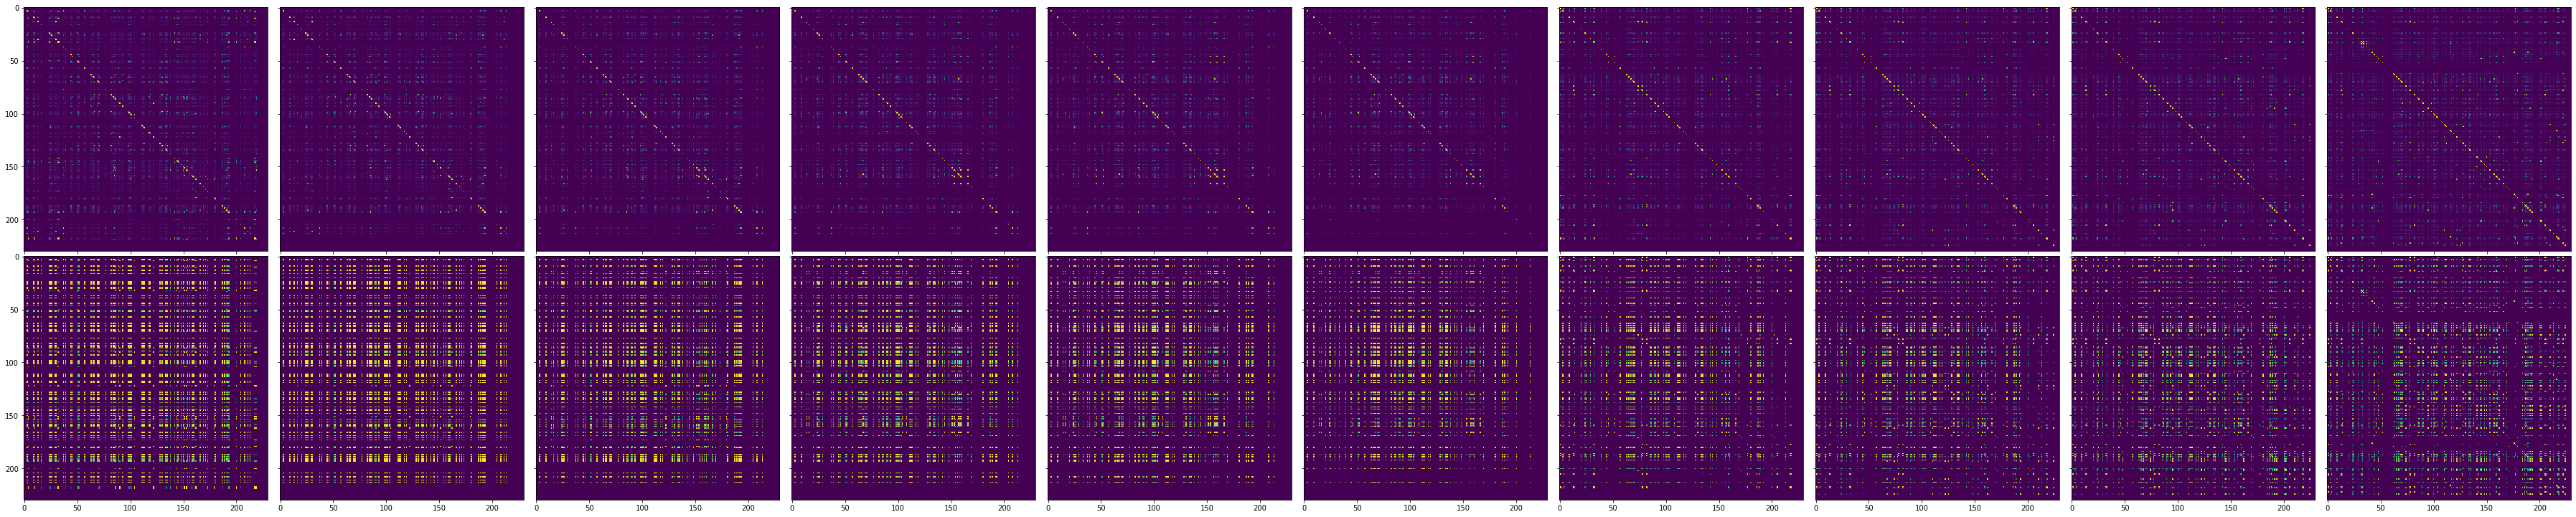

In [290]:
n_vis= 10
dil_vis = 100
fig, axes = plt.subplots(ncols=n_vis, nrows=2, figsize=(5*n_vis,10), sharex=True, sharey=True)
for i,p1,p2 in zip(range(n_vis), corr_paths[::dil_vis][:n_vis], pf_paths[::dil_vis][:n_vis]):
    s = np.load(p1)[neurons_selected][:,neurons_selected]
    p = np.load(p2)[neurons_selected][:,neurons_selected]
    axes[0,i].imshow(s)
    axes[1,i].imshow(p)
plt.tight_layout()
plt.show()

In [418]:
def l2_distance(p1,p2, neurons_selected=None, use_nonsinge_nodes=False):
    
    s = np.load(p1)
    p = np.load(p2)
    
    if neurons_selected is not None:
        s = s[neurons_selected][:,neurons_selected]
        p = p[neurons_selected][:,neurons_selected]

    N = s.shape[0]
    non_single_nodes = np.arange(N)
    if use_nonsinge_nodes:
        non_single_nodes = non_single_nodes[(s.sum(0)>0)*(p.sum(0)>0)]
        
    if len(non_single_nodes) >= 2:
        s = s[non_single_nodes][:,non_single_nodes]
        p = p[non_single_nodes][:,non_single_nodes]
    
        m = np.linalg.norm(s - p) / N**2
    
    else:
        m = np.nan
    
    return m

In [419]:
def compare_active_time_windows(p1, p2, neurons_selected=None, use_nonsingle=True):

    A1 = np.load(p1)
    A2 = np.load(p2)
    
    if neurons_selected is not None:
        A1 = A1[neurons_selected][:,neurons_selected]
        A2 = A2[neurons_selected][:,neurons_selected]
    
    N = A1.shape[0]
    
    non_single_nodes = np.arange(N)[(A1.sum(0)>0)*(A2.sum(0)>0)]
    if len(non_single_nodes) >= 2:

        A1_n = A1[non_single_nodes][:,non_single_nodes]
        A2_n = A2[non_single_nodes][:,non_single_nodes]
        
        d1 = compute_norm_laplacian_eig(A1_n)
        d2 = compute_norm_laplacian_eig(A2_n)

        v1 = get_first_k_eig(*d1, k=15)
        v2 = get_first_k_eig(*d2, k=15)
        
        n = v1.shape[0]
        d = np.linalg.norm((np.ones((n,n)) - v1@v1.T)@v2@v2.T )

        return d
    else:
        return np.nan 

In [420]:
def mape(y,y_pred):
    mae = np.linalg.norm(y - y_pred, ord=1, axis=1, keepdims=True) /  np.linalg.norm(y, ord=1, axis=1, keepdims=True)
    return mae.mean()

In [421]:
def calculate_pf_metrics(corr_paths, pf_paths, neurons_selected, n_jobs=-1):
    metrics = {}
    metrics['lap_values'] = Parallel(n_jobs=n_jobs, verbose=1)(delayed(compare_active_time_windows)(p1, p2, neurons_selected=neurons_selected) \
                                                    for p1,p2 in tqdm_notebook(zip(corr_paths, pf_paths)))
    metrics['lap_values_random'] = Parallel(n_jobs=n_jobs, verbose=1)(delayed(compare_active_time_windows)(p1, p2) \
                                                           for p1,p2 in tqdm_notebook(zip(np.random.choice(corr_paths, size=1000), 
                                                                                           np.random.choice(pf_paths, size=1000))))

    metrics['fro'] = Parallel(n_jobs=-n_jobs, verbose=1)(delayed(l2_distance)(p1, p2, neurons_selected=neurons_selected) for p1,p2 in tqdm_notebook(zip(corr_paths, pf_paths)))
    metrics['fro_random'] = Parallel(n_jobs=n_jobs, verbose=1)(delayed(l2_distance)(p1, p2) for p1,p2 in tqdm_notebook(zip(np.random.choice(corr_paths, size=1000), 
                                                                                                                       np.random.choice(pf_paths, size=1000))))
    clear_output()
    return metrics

# Metrics by STD threshold

In [422]:
# metrics_by_threshold = defaultdict(dict)
# stds_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]

# fro_random = Parallel(n_jobs=-1, verbose=1)(delayed(l2_distance)(p1, p2) for p1,p2 in tqdm_notebook(zip(np.random.choice(corr_paths, size=1000), 
#                                                                                                        np.random.choice(pf_paths, size=1000))))
# fro_random = np.array(fro_random)
# fro_random_mean = fro_random[~np.isnan(fro_random)].mean()

# for i,std_thresh in enumerate(stds_thresholds):
#     print('neurons selected', len(neurons_selected), f'{i/len(stds_thresholds)}%')
#     mask = (stds_sorted < std_thresh)*(total_activity_[neurons_by_std] > 0.05)
#     neurons_selected = neurons_by_std[mask]
    
#     fro = Parallel(n_jobs=-1, verbose=1)(delayed(l2_distance)(p1, 
#                                                               p2, 
#                                                               neurons_selected=neurons_selected, 
#                                                               use_nonsinge_nodes=True) for p1,p2 in tqdm_notebook(zip(corr_paths, pf_paths)))
    
#     clear_output()
    
    
#     fro = pd.Series(data=fro).fillna(method='ffill').fillna(method='bfill').values

#     metrics_by_threshold[std_thresh]['fro'] = fro
#     metrics_by_threshold[std_thresh]['neurons_selected'] = neurons_selected

In [423]:
# cadata_ = StandardScaler().fit_transform(cadata.T)
# scorer = make_scorer(mape, greater_is_better=False)

# mean_mae = []

# for i,std_thresh in enumerate(stds_thresholds):
#     mask = (stds_sorted < std_thresh)*(total_activity_[neurons_by_std] > 0.05)
#     neurons_selected = neurons_by_std[mask]
#     est = RegressorChain(Ridge()) # n_jobs=-1
#     mean_mae.append(-cross_val_score(est, cadata_[:, neurons_selected], coords_, scoring=scorer, cv=3).mean()) # [1000:3000]

# Metrics

In [ ]:
metrics = calculate_pf_metrics(corr_paths, pf_paths, neurons_selected, n_jobs=30)

/media/hpc2_storage/ibulygin/miniconda3/envs/fresh/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    8.0s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:   15.1s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:   25.3s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   38.3s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:   47.6s
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:   56.0s
[Parallel(n_jobs=30)]: Done 3380 tasks      | elapsed:  1.8min
[Parallel(n_jobs=30)]: Done 4230 tasks      | elapsed:  2.8min
[Parallel(n_jobs=30)]: Done 5180 tasks      | elapsed:  4.0min
[Parallel(n_jobs=30)]: Done 6230 tasks      | elapsed:  5.3min


In [ ]:
for k,v in metrics.items():
    series = pd.Series(data=v).fillna(method='ffill').fillna(method='bfill')
    metrics[k] = series.values

In [ ]:
lap_values_all = MinMaxScaler().fit_transform(np.concatenate([metrics['lap_values'], metrics['lap_values_random']])[:,None]).flatten()
metrics['lap_values_'] = lap_values_all[:len(metrics['lap_values'])]
metrics['lap_values_random_'] = lap_values_all[len(metrics['lap_values']):]

fro_values_all = MinMaxScaler().fit_transform(np.concatenate([metrics['fro'], metrics['fro_random']])[:,None]).flatten()
metrics['fro_'] = fro_values_all[:len(metrics['fro'])]
metrics['fro_random_'] = fro_values_all[len(metrics['fro']):]

In [ ]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(metrics['fro_'], label='Normalized Frobenius')
plt.hlines(np.mean(metrics['fro_random_']), 0, len(metrics['fro']), label='Random Frobenius', alpha=0.3, color='red', linestyle='--')
plt.title(corr_dir.split('corrmaps')[1][1:] + f'_hist2d-bins{bins}'+ '_SELECTED-VLAD')# 
plt.xlabel('t')
plt.ylabel('Frobenius norm: |S-P|')
plt.legend()
plt.show()

In [ ]:
corr_dir.split('corrmaps')[1][1:] + f'_hist2d-bins{bins}' + '_SELECTED-VLAD' #+ '_SELECTED-VLAD'

In [ ]:
plt.figure(figsize=(15,5),dpi=200)
plt.plot(metrics['lap_values_'], label='Similarity')
plt.hlines(np.mean(metrics['lap_values_random_']), 0, len(metrics['lap_values']), label='Randomized similarity', alpha=0.3, color='red', linestyle='--')
plt.title(corr_dir.split('corrmaps')[1][1:] + f'_hist2d-bins{bins}'+ '_SELECTED-VLAD') #  + '_SELECTED-VLAD'
# plt.plot(rears_indicators_abs, color='green', alpha=0.3)
# plt.plot(speed_, alpha=0.3)
plt.xlabel('t')
plt.ylabel('Normalized k-Laplacian eigv similarity')
plt.legend()
plt.show()

In [ ]:
# corr_dir.split('corrmaps')[1][1:] + f'_hist2d-bins{bins}'

In [241]:
metrics_name =f'./SP_experiments/' + corr_dir.split('corrmaps')[1][1:] + f'_hist2d-bins{bins}'
print(metrics_name)
# np.save(metrics_name, metrics)

./SP_experiments/Circle_M22_D1_diag_dt1000_kernel49_gaussian_SYGMA8_hist2d-bins25


 - what is the origin of periodicity?
 - need some strong argument how 'order' neurons by their place specificity, std is too simple?

In [614]:
# from scipy.stats import 

# Check difference

In [373]:
# lap_argmax = np.argmin(metrics['lap_values'])

# s_argmx = corr_paths[lap_argmax]
# p_argmx = pf_paths[lap_argmax]

# fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5), sharex=True, sharey=True)
# s = np.load(s_argmx)
# p = np.load(p_argmx)
# axes[0].imshow(s)
# axes[1].imshow(p)
# plt.show()

In [370]:
# fro_argmax = np.argmax(metrics['fro_'])

# s_argmx = corr_paths[fro_argmax]
# p_argmx = pf_paths[fro_argmax]

# fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5), sharex=True, sharey=True)
# s = np.load(s_argmx)
# p = np.load(p_argmx)
# axes[0].imshow(s)
# axes[1].imshow(p)
# plt.show()